# CVAL Semantic Segmentation SaaS

## Install

In [ ]:
!pip install cval-lib

## Prepare

In [ ]:
import os
from pathlib import Path
import random
import time
from tqdm import tqdm

from cval_lib.connection import CVALConnection
from cval_lib.frame import FrameModel
from cval_lib.annotation import Mask, ImageSegAnnotation, SegmentationAnnotation

In [ ]:
USER_API_KEY = '...'

In [ ]:
CONNECTION = CVALConnection(USER_API_KEY)

In [ ]:
def load_annotations_yolo(labels_path: str, start=None, end=None, samples=None):
    annotations = []
    for i in tqdm(os.listdir(labels_path)[start:end]):
      p = Path(labels_path) / i
      if samples is not None and p.stem in samples:
        with open(p, encoding='utf-8') as f:
            masks = []
            for mask in f.read().strip().split('\n'):
                if mask:
                    label_mask_str_lst = mask.strip().split(' ')
                    label = int(label_mask_str_lst[0])
                    bbox = list(map(float, label_mask_str_lst[1:]))
                    masks.append(Mask(label=label, mask=bbox))
        annotations.append(
            ImageSegAnnotation(image_id=Path(i).stem + '.png', masks=masks)
        )
    return annotations

In [ ]:
def load_images(images_path: str):
  for i in os.lisdtir(images_path):
    p = Path(images_path) / i
    with open(p, 'rb') as f:
      yield FrameModel(img_raw=f.read(), img_external_id=p.name)

In [ ]:
DATASET_ID = CONNECTION.dataset().create()

In [ ]:
PATH_TO_TRAIN = '/content/train/images'
PATH_TO_VAL = '/content/val/images'
PATH_TO_TEST = '/content/test/images'

TRAIN = load_images(PATH_TO_TRAIN)
VAL = load_images(PATH_TO_VAL)
TEST = load_images(PATH_TO_TEST)

CONNECTION.frames('training').create_fb(DATASET_ID, list(TRAIN))
CONNECTION.frames('test').create_fb(DATASET_ID, list(TEST))
CONNECTION.frames('validation').create_fb(DATASET_ID, list(VAL))

## Run Sampling

### SaaS sampling

In [ ]:
PATH_TO_TRAIN = '/content/train/labels'
PATH_TO_VAL = '/content/val/labels'
PATH_TO_TEST = '/content/test/labels'

TRAIN_INITIAL = load_annotations_yolo(PATH_TO_TRAIN, None, 100)
VAL = load_annotations_yolo(PATH_TO_VAL)
TEST = load_annotations_yolo(PATH_TO_TEST)

CONNECTION.seg_annotation(DATASET_ID).create(
    SegmentationAnnotation(
        train=TRAIN,
        test=TEST,
        val=VAL,
    )
)

In [ ]:
NUM_STEPS = 6
NUM_SAMPLES = 1000 # num samples for al sampling

PATH_TO_TRAIN = '/content/train/labels'
METRICS_CVAL = []
MODEL_TYPE = 'yolo' # yolo for instance segmentation, unet for semantic segmentation (singleclass support only)

for i in range(NUM_STEPS):
  result = CONNECTION.segmentation().saas_sampling(DATASET_ID, MODEL_TYPE).result
  flag = True
  while flag:
    result_train = CONNECTION.result.get(result.task_id)
    time.sleep(10)
    if result_train.result is not None:
      result_test = CONNECTION.segmentation().saas_test(DATASET_ID, 'yolo').result
      while 1:
        result_test = CONNECTION.result.get(result.task_id)
        time.sleep(10)
        if result_test.result is not None:
          samples = result_train.result['samples'][:NUM_SAMPLES]
          train = load_annotations_yolo(PATH_TO_TRAIN, samples=samples)
          CONNECTION.seg_annotation(DATASET_ID).create(
                SegmentationAnnotation(
                    train=train+TRAIN_INITIAL,
                    test=TEST,
                    val=VAL,
                )
            )
          flag = False
          time.sleep(2)
          METRICS_CVAL.append(
              result_test.result['metric']
          )
          break

### Random sampling

In [ ]:
PATH_TO_TRAIN = '/content/train/labels'
PATH_TO_VAL = '/content/val/labels'
PATH_TO_TEST = '/content/test/labels'

TRAIN_INITIAL = load_annotations_yolo(PATH_TO_TRAIN, None, 100)
VAL = load_annotations_yolo(PATH_TO_VAL)
TEST = load_annotations_yolo(PATH_TO_TEST)

CONNECTION.seg_annotation(DATASET_ID).create(
    SegmentationAnnotation(
        train=TRAIN,
        test=TEST,
        val=VAL,
    )
)

In [ ]:
NUM_STEPS = 6
NUM_SAMPLES = 1000

PATH_TO_TRAIN = '/content/train/lebels'
METRICS_RANDOM = []
TRAIN_IDS = list(map(lambda x: (Path(PATH_TO_TRAIN) / x).stem, os.listdir(PATH_TO_TRAIN)))

for i in range(NUM_STEPS):
    if result_train.result is not None:
      result_test = CONNECTION.segmentation().saas_test(DATASET_ID, 'yolo').result
      while 1:
        result_test = CONNECTION.result.get(result.task_id)
        time.sleep(10)
        if result_test.result is not None:
          samples = random.sample(TRAIN_IDS, NUM_SAMPLES)

          train = load_annotations_yolo(PATH_TO_TRAIN, samples=samples)
          CONNECTION.seg_annotation(DATASET_ID).create(
                SegmentationAnnotation(
                    train=train+TRAIN_INITIAL,
                    test=TEST,
                    val=VAL,
                )
            )
          time.sleep(2)
          METRICS_RANDOM.append(
              result_test.result['metric']
          )
          break

### Profit!

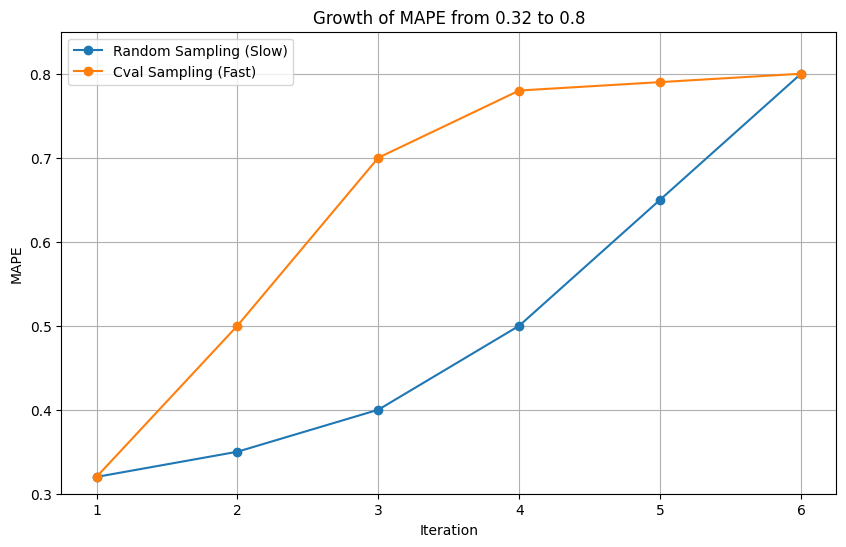

In [5]:
import numpy as np
import matplotlib.pyplot as plt
iterations = np.arange(1, 7)
plt.figure(figsize=(10, 6))
plt.plot(iterations, METRICS_RANDOM, marker='o', label='Random Sampling (Slow)')
plt.plot(iterations, METRICS_CVAL, marker='o', label='Cval Sampling (Fast)')
plt.title('Growth of MAPE from 0.32 to 0.8')
plt.xlabel('Iteration')
plt.ylabel('MAPE')
plt.ylim(0.3, 0.85)
plt.grid(True)
plt.legend()
plt.show()

> Profit!

## After all: on-premise

for on-premise sampling try [cval on premise YOLO](https://github.com/fangorntb/cval-lib/blob/main/ipynb/cval_on_premise_YOLO.ipynb)